# Добро пожаловать на задание уровня Ultra Pro.

В данном задании требуется на базе клеток сделать задачу сегментации с вниманием.

Хотелось бы отметить что данное задание является сложным и Вам потребуется самостоятельно разобраться как правильно включить блок внимания в задачу сегментации.


Успехов!

#Для этой задачи я взял готовую сеть SUIM для сегментации с механизмом внимания tripple attention
О этой сети можно почитать тут https://github.com/Vafelka1/SegmentationWithAttention/blob/main/poster.pdf



In [ ]:
# Загрузить библиотеку OpenCV для загрузки файлов
import cv2

# Загрузим библиотеку Numpy
import numpy as np

# # Импортируем модель для загрузки файлов
from glob import glob

#
from matplotlib import pylab as plt

# Импортируем слои
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout, UpSampling2D, Add, Multiply, Input, Concatenate, MaxPooling2D

# Импортируем Model
from keras.models import Model

# Импортируем оптимизатор
from tensorflow.keras.optimizers import Adam

# Импортируем backend keras
from keras import backend as K

In [ ]:
# Подключаем диск
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l4/cellbase.zip', None, quiet=True)

'cellbase.zip'

In [ ]:
# Распаковываем zip-файл базы
!unzip -q -o 'cellbase.zip'

In [ ]:
!rm -f -r /content/SegmentationWithAttention

In [ ]:
!git clone https://github.com/Vafelka1/SegmentationWithAttention

Cloning into 'SegmentationWithAttention'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 92 (delta 23), reused 0 (delta 0), pack-reused 40
Receiving objects: 100% (92/92), 72.26 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
from PIL import Image
import os
def change_image_extension(img_fold,label_fold,test_fold):
  for item in sorted(os.listdir(img_fold)):
    path = f"{img_fold}/{item}"
    img = Image.open(path)
    new_path = path.split('.')[0]+'.jpg'
    os.remove(path)
    img.save(new_path)

  for item in sorted(os.listdir(label_fold)):
    path = f"{label_fold}/{item}"
    img = Image.open(path)
    new_path = path.split('.')[0]+'.jpg'
    os.remove(path)
    img.save(new_path)

  for item in sorted(os.listdir(test_fold)):
    path = f"{test_fold}/{item}"
    img = Image.open(path)
    img = img.convert('1')
    new_path = path.split('.')[0]+'.jpg'
    os.remove(path)
    img.save(new_path)


change_image_extension('train','label','test')

In [ ]:
from __future__ import print_function, division
import os
import math
from os.path import join, exists
from keras import callbacks
# local libs
from SegmentationWithAttention.materials.models.suim_net import SUIM_Net

In [ ]:
dataset_name = "suim"
train_dir = "/content"

In [ ]:
ckpt_dir = "/content/SegmentationWithAttention/materials/models/weights"
base_ = 'RSB' # or 'VGG'
if base_=='RSB':
    im_res_ = (320, 240, 3)
    ckpt_name = "suimnet_rsb02.hdf5"
else:
    im_res_ = (320, 256, 3)
    ckpt_name = "suimnet_vgg.hdf5"
model_ckpt_name = join(ckpt_dir, ckpt_name)
if not exists(ckpt_dir): os.makedirs(ckpt_dir)

In [ ]:
suimnet = SUIM_Net(base=base_, im_res=im_res_, n_classes=1)
model = suimnet.model
print (model.summary())

Triplet Attention!
ATTENTION!


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 236, 316, 64)         4864      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 236, 316, 64)         256       ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 236, 316, 64)         0         ['batch_normalization_3[0]

In [ ]:
batch_size = 4
num_epochs = 40

In [ ]:

# setup data generator
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [ ]:
import tensorflow as tf
def scheduler(epoch, lr):
   if epoch < 7:
     return lr
   else:
     return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_checkpoint = callbacks.ModelCheckpoint(model_ckpt_name,
                                   monitor = 'loss',
                                   verbose = 1, mode= 'auto',
                                   save_weights_only = True,
                                   save_best_only = True)

In [ ]:
def getSaliency(mask):
    # one combined category: HD/RO/FV/WR
    imw, imh = mask.shape[0], mask.shape[1]
    sal = np.zeros((imw, imh))
    for i in range(imw):
        for j in range(imh):
            if (mask[i,j,0]<=125 and mask[i,j,1]<=125 and mask[i,j,2]<=125):
                sal[i, j] = 1
            elif (mask[i,j,0]>=125 and mask[i,j,1]>=125 and mask[i,j,2]>=125):
                sal[i, j] = 1
            else: pass
    return np.expand_dims(sal, axis=-1)

In [ ]:
def processSUIMDataRFHW(img, mask, sal=True):
    # scaling image data and masks
    mask = mask / 255
    #mask = mask.astype('int8')

    m = []
    #for i in range(mask.shape[0]):
    #    if sal:
    #        m.append(getSaliency(mask[i]))
    #    else:
    #        print('Миша,давай по новой')
    #m = np.array(m)

    #return (img, m)
    return (img, mask)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def trainDataGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode="grayscale",
                    mask_color_mode="grayscale", target_size=(256,256), sal=True):
    # data generator function for driving the training
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "image",
        seed=1)
    # mask generator function for corresponding ground truth
    mask_datagen = ImageDataGenerator(**aug_dict)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "mask",
        seed = 1)
    # make pairs and return
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask_indiv = processSUIMDataRFHW(img, mask, sal)
        yield (img, mask_indiv)
        #print(img.shape)
        #print(mask_indiv)
        #print(np.count_nonzero(mask_indiv))

In [ ]:
# data generator

train_gen = trainDataGenerator(batch_size, # batch_size
                              train_dir,# train-data dir
                              "train", # image_folder
                              "label", # mask_folder
                              data_gen_args, # aug_dict
                              image_color_mode="rgb",
                              mask_color_mode="grayscale",
                              target_size = (im_res_[1], im_res_[0]))

In [ ]:
num_epochs = 2

suimnet2 = model.fit(train_gen,
                    steps_per_epoch = 10,
                    epochs = num_epochs,
                    callbacks = [model_checkpoint,
                                 lr_callback])

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.5467
Epoch 1: loss improved from 0.23721 to 0.23646, saving model to /content/SegmentationWithAttention/materials/models/weights/suimnet_rsb02.hdf5
10/10 [==============================] - 3s 269ms/step - loss: 0.2365 - accuracy: 0.5467 - lr: 2.7253e-04
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.5484
Epoch 2: loss improved from 0.23646 to 0.23478, saving model to /content/SegmentationWithAttention/materials/models/weights/suimnet_rsb02.hdf5
10/10 [==============================] - 3s 279ms/step - loss: 0.2348 - accuracy: 0.5484 - lr: 2.7253e-04


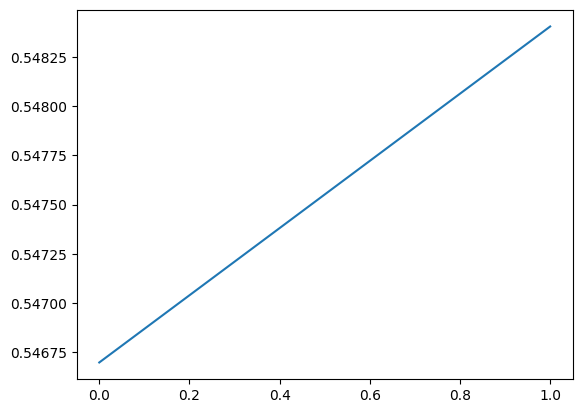

In [ ]:
import matplotlib.pyplot as plt
plt.plot(suimnet2.history['accuracy'])

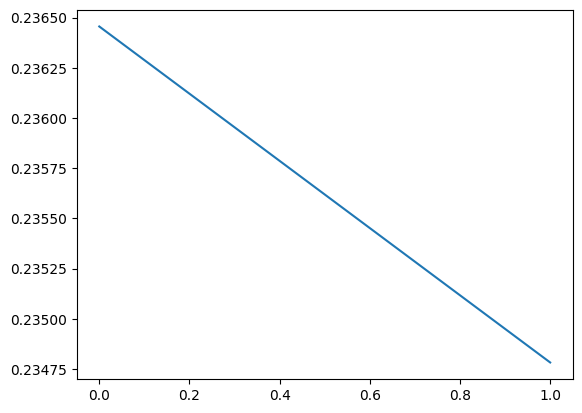

In [ ]:
plt.plot(suimnet2.history['loss'])

In [ ]:
img = Image.open('/content/test/2.jpg')
im = img.convert('RGB')
im = im.resize((320, 240))
im = np.array(im)
im = np.expand_dims(im, axis=0)
ans = model.predict(im)
answer = np.squeeze(ans,axis=0)

1/1 [==============================] - 0s 21ms/step


In [ ]:
def ch_arr(arr):
  for i in range(240):
    for j in range(320):
      arr[i,j] = 1 - arr[i,j]
  return arr
imag = ch_arr(answer)

#Изображение из сети

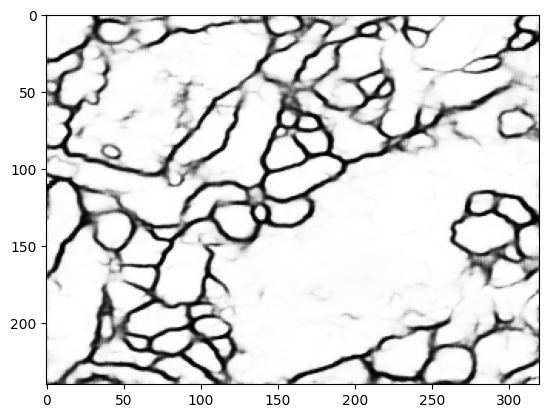

In [ ]:
plt.imshow(imag, cmap='Greys')

#Изображение с теста

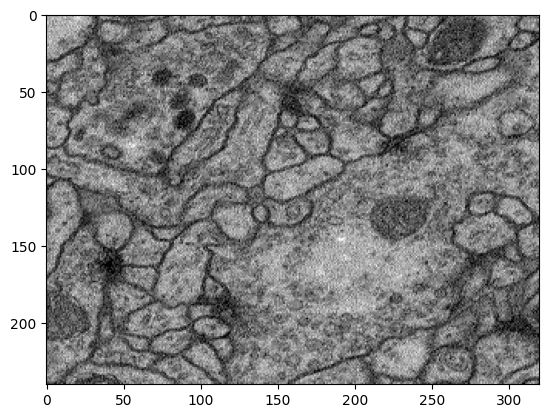

In [ ]:
img = Image.open('/content/test/2.jpg')
#im = img.convert('Gray')
im = img.resize((320, 240))
im = np.array(im)/255
#im = im.astype('int8')
plt.imshow(im,cmap="gray")

Точность можно подкрутить, но уже видно что сеть с attention работает